<a href="https://colab.research.google.com/github/mercadoerik1031/snn-sound-localization/blob/new_approach/snn_sound_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SNN Sounnd Localization**



---



In [7]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# pip Installs

# Imports

In [18]:
import librosa
import numpy as np

import matplotlib.pyplot as plt

import os

import torch

# Config

In [9]:
config = {
    # Paths
    "metadata_path": r"/content/drive/My Drive/Colab Notebooks/Masters Project/metadata.parquet",
    "ambisonic_path": r"/content/drive/My Drive/Colab Notebooks/Masters Project/spatial_librispeech_sample/ambisonics_sample",
    "noise_path": r"/content/drive/My Drive/Colab Notebooks/Masters Project/spatial_librispeech_sample/noise_ambisonics_sample",

    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    # Audio Info
    "sr":16_000,
}

# Preprocess

## Load and Normalize

In [24]:
def load_and_normalize(ambisonics_path, noise_path=None, sr=config["sr"]):
  ambisonic, _ = librosa.load(ambisonics_path, sr=sr, mono=False)

  # If a noise path is provided, load and combine it with the Ambisonics audio
  if noise_path:
    noise, _ = librosa.load(noise_path, sr=sr, mono=False)
    combined = ambisonic + noise
    normalized = combined / np.max(np.abs(combined))  # Normalize the combined signal

  else:
    normalized = ambisonic / np.max(np.abs(ambisonic))  # Normalize only the Ambisonics audio

  return normalized

In [25]:
a_pth = config["ambisonic_path"]
n_pth = config["noise_path"]

a_pth = os.path.join(a_pth, "000156.flac")
n_pth = os.path.join(n_pth, "000156.flac")

audio = load_and_normalize(a_pth)
audio_n = load_and_normalize(a_pth, n_pth)

In [26]:
W = audio[0]
X = audio[1]
Y = audio[2]
Z = audio[3]

W_n = audio_n[0]
Y_n = audio_n[2]
X_n = audio_n[1]
Z_n = audio_n[3]

print()

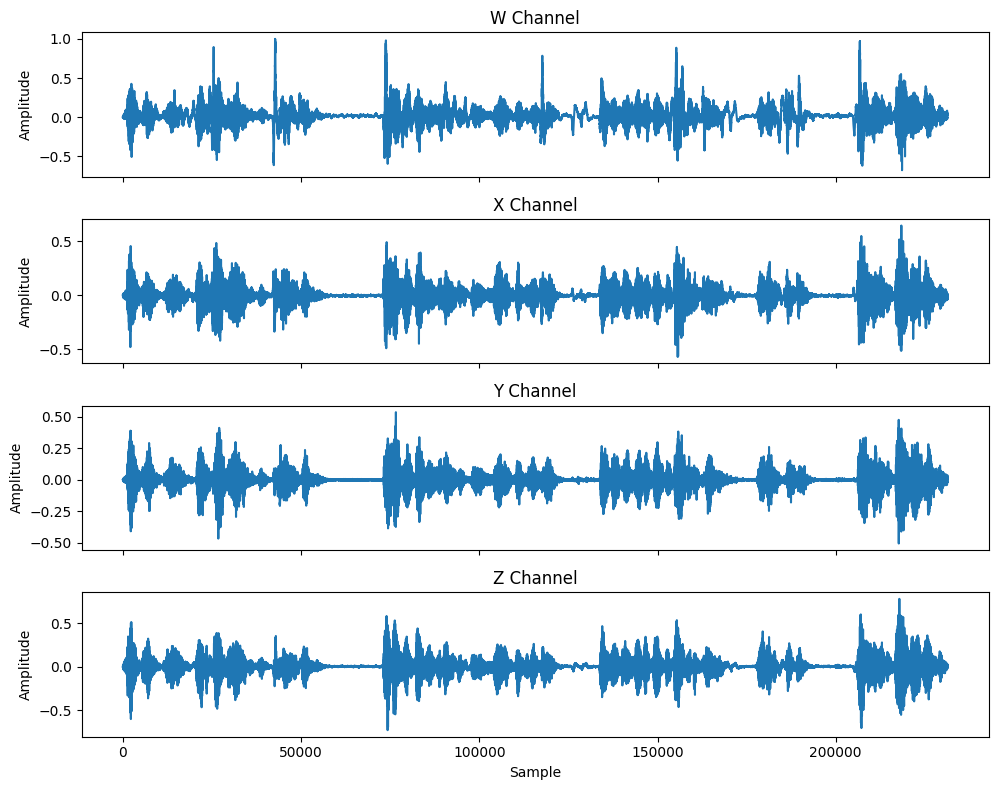

In [19]:
# Plot each channel
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axs[0].plot(W)
axs[0].set_title('W Channel')

axs[1].plot(X)
axs[1].set_title('X Channel')

axs[2].plot(Y)
axs[2].set_title('Y Channel')

axs[3].plot(Z)
axs[3].set_title('Z Channel')

# Common settings for all subplots
for ax in axs:
    ax.set_ylabel('Amplitude')
    ax.label_outer()

axs[-1].set_xlabel('Sample')

plt.tight_layout()
plt.show()
